[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/husseinlopez/diplomadoIA/blob/main/M1-6_Ejercicios_Validacion.ipynb)

# Módulo 1: Introducción a la Minería de Datos
## Ejercicios Prácticos de Validación y Evaluación de Modelos

**Diplomado en Inteligencia Artificial**  
Dr. Irvin Hussein López Nava  
CICESE - UABC

---

## Objetivos de esta sesión

1. **Comprender la importancia de la partición de datos** para evaluar generalización
2. **Implementar diferentes esquemas de validación**: Hold-out, k-Fold CV, Leave-One-Out
3. **Aplicar métricas de regresión**: MAE, MSE, RMSE, R²
4. **Aplicar métricas de clasificación**: Accuracy, Precision, Recall, F1, ROC-AUC, MCC
5. **Evitar data leakage** en el pipeline de evaluación
6. **Interpretar resultados** considerando sesgo y varianza

---

## Estructura del notebook

### Parte 1: Esquemas de Partición y Validación
* Hold-out simple
* k-Fold Cross-Validation
* Leave-One-Out Cross-Validation
* Estratificación

### Parte 2: Evaluación de Modelos de Regresión
* Métricas: MAE, MSE, RMSE, R²
* Comparación de modelos
* Análisis de residuos

### Parte 3: Evaluación de Modelos de Clasificación
* Matriz de confusión
* Métricas: Accuracy, Precision, Recall, F1
* Curva ROC y AUC
* Matthews Correlation Coefficient (MCC)

### Parte 4: Comparación de Modelos y Mejores Prácticas
* Variabilidad del desempeño
* Data leakage (cómo evitarlo)
* Selección de métricas según contexto

---
## 0. Configuración del Entorno

Importaremos las bibliotecas necesarias para validación y evaluación.

In [1]:
# Manejo de datos
import numpy as np
import pandas as pd
from scipy import stats

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Reproducibilidad
np.random.seed(42)

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ Bibliotecas básicas importadas")

✓ Bibliotecas básicas importadas


In [2]:
# Machine Learning
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    KFold,
    StratifiedKFold,
    LeaveOneOut
)

# Modelos
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC

# Preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Métricas de regresión
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# Métricas de clasificación
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    matthews_corrcoef
)

# Datasets
from sklearn.datasets import (
    load_diabetes,
    load_breast_cancer,
    make_classification,
    make_regression
)

print("✓ Bibliotecas de ML importadas correctamente")

✓ Bibliotecas de ML importadas correctamente


---
# Parte 1: Esquemas de Partición y Validación

**Objetivo**: Entender CÓMO se dividen los datos, sin entrenar modelos todavía.

Veremos visualmente qué observaciones van a cada conjunto.

## 1.1 ¿Por qué particionar los datos?

**Problema fundamental**:
- El modelo se ajusta minimizando el error en los datos de entrenamiento
- Si evaluamos en los mismos datos, el error será **optimista**
- No sabremos si el modelo **generaliza** a datos nuevos

**Solución**:
- Separar datos en **entrenamiento** y **prueba**
- Entrenar solo con training
- Evaluar solo con test (datos "no vistos")

En esta parte veremos la **mecánica de la partición**, no el modelado.

## 1.2 Dataset de Ejemplo

Usaremos un dataset pequeño para visualizar claramente las particiones.

In [3]:
# Crear dataset pequeño para visualización
np.random.seed(42)

# 30 observaciones para fácil visualización
n_samples = 30
X_visual = np.random.randn(n_samples, 5)
y_visual = np.random.randint(0, 2, n_samples)

# Crear DataFrame para mejor visualización
df_visual = pd.DataFrame({
    'ID': range(n_samples),
    'Clase': y_visual,
    'Feature_1': X_visual[:, 0],
    'Feature_2': X_visual[:, 1]
})

print("="*80)
print("DATASET DE EJEMPLO PARA VISUALIZACIÓN")
print("="*80)
print(f"\nTotal de observaciones: {n_samples}")
print(f"\nPrimeras 10 observaciones:")
print(df_visual.head(10))

print(f"\nDistribución de clases:")
print(df_visual['Clase'].value_counts().sort_index())

DATASET DE EJEMPLO PARA VISUALIZACIÓN

Total de observaciones: 30

Primeras 10 observaciones:
   ID  Clase  Feature_1  Feature_2
0   0      1   0.496714  -0.138264
1   1      1  -0.234137   1.579213
2   2      1  -0.463418  -0.465730
3   3      0  -0.562288  -1.012831
4   4      1   1.465649  -0.225776
5   5      1   0.110923  -1.150994
6   6      0  -0.601707   1.852278
7   7      0  -1.220844   0.208864
8   8      1   0.738467   0.171368
9   9      1  -0.719844  -0.460639

Distribución de clases:
Clase
0    10
1    20
Name: count, dtype: int64


## 1.3 Hold-Out Simple

La estrategia más básica: una sola partición en train y test.

HOLD-OUT SIMPLE (70% Train - 30% Test)

Total: 30 observaciones
Training: 21 observaciones (70%)
Test: 9 observaciones (30%)

Índices en Training: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 16, 18, 19, 20, 21, 22, 25, 26, 29]

Índices en Test: [8, 9, 12, 15, 17, 23, 24, 27, 28]


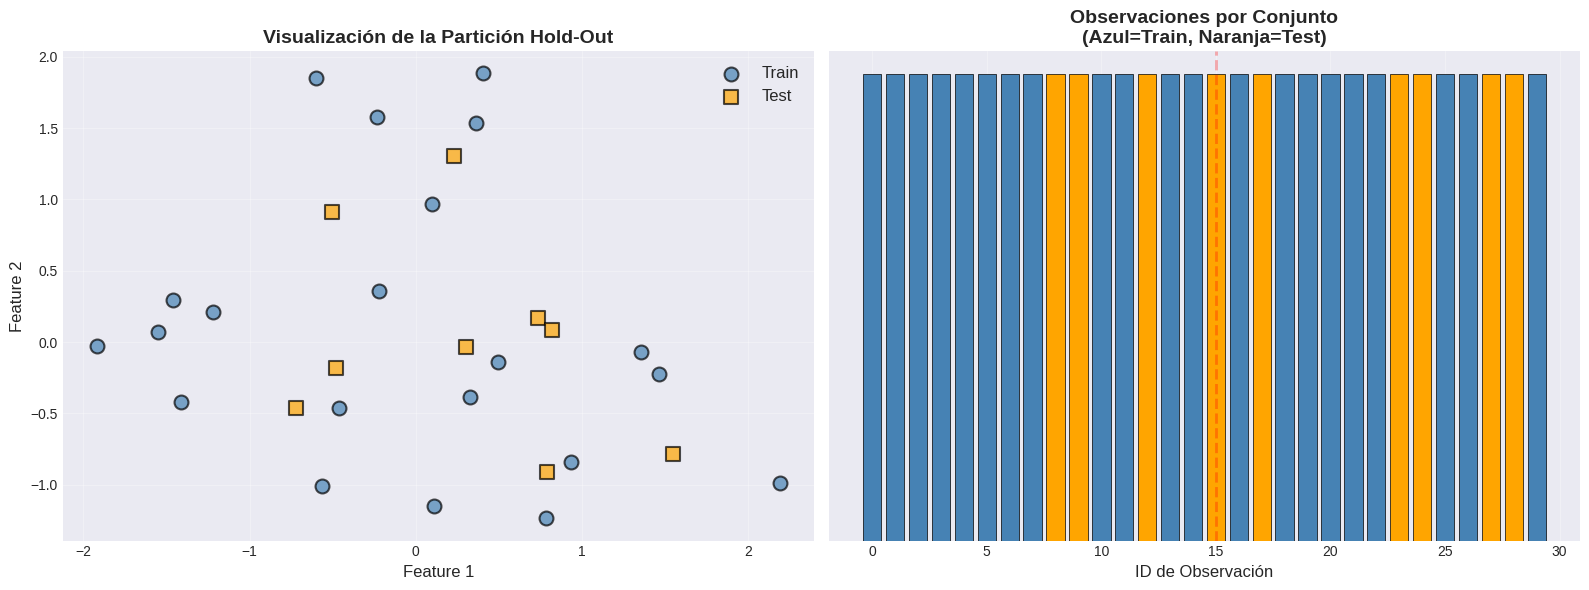


✓ Cada observación está en exactamente UN conjunto
✓ Train y Test son disjuntos (no se traslapan)


In [4]:
# Hold-out 70-30
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(
    np.arange(n_samples),
    test_size=0.3,
    random_state=42
)

print("="*80)
print("HOLD-OUT SIMPLE (70% Train - 30% Test)")
print("="*80)

print(f"\nTotal: {n_samples} observaciones")
print(f"Training: {len(train_idx)} observaciones ({100*len(train_idx)/n_samples:.0f}%)")
print(f"Test: {len(test_idx)} observaciones ({100*len(test_idx)/n_samples:.0f}%)")

print(f"\nÍndices en Training: {sorted(train_idx.tolist())}")
print(f"\nÍndices en Test: {sorted(test_idx.tolist())}")

# Crear DataFrame para visualización
df_partition = df_visual.copy()
df_partition['Conjunto'] = 'Test'
df_partition.loc[train_idx, 'Conjunto'] = 'Train'

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot mostrando la partición
ax = axes[0]
for conjunto, color, marker in [('Train', 'steelblue', 'o'), ('Test', 'orange', 's')]:
    mask = df_partition['Conjunto'] == conjunto
    ax.scatter(df_partition.loc[mask, 'Feature_1'],
              df_partition.loc[mask, 'Feature_2'],
              c=color, label=conjunto, s=100, alpha=0.7,
              edgecolors='black', linewidth=1.5, marker=marker)

ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_title('Visualización de la Partición Hold-Out', fontweight='bold', fontsize=14)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

# Gráfico de barras por ID
ax = axes[1]
colors = ['steelblue' if c == 'Train' else 'orange' for c in df_partition['Conjunto']]
ax.bar(df_partition['ID'], [1]*n_samples, color=colors, edgecolor='black', linewidth=0.5)
ax.set_xlabel('ID de Observación', fontsize=12)
ax.set_ylabel('')
ax.set_title('Observaciones por Conjunto\n(Azul=Train, Naranja=Test)', fontweight='bold', fontsize=14)
ax.set_yticks([])
ax.grid(alpha=0.3, axis='x')

# Añadir línea separadora visual
train_count = len(train_idx)
ax.axvline(x=15, color='red', linestyle='--', linewidth=2, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Cada observación está en exactamente UN conjunto")
print(f"✓ Train y Test son disjuntos (no se traslapan)")

### Variabilidad del Hold-Out

La partición depende del `random_state`. Veamos cómo cambia:

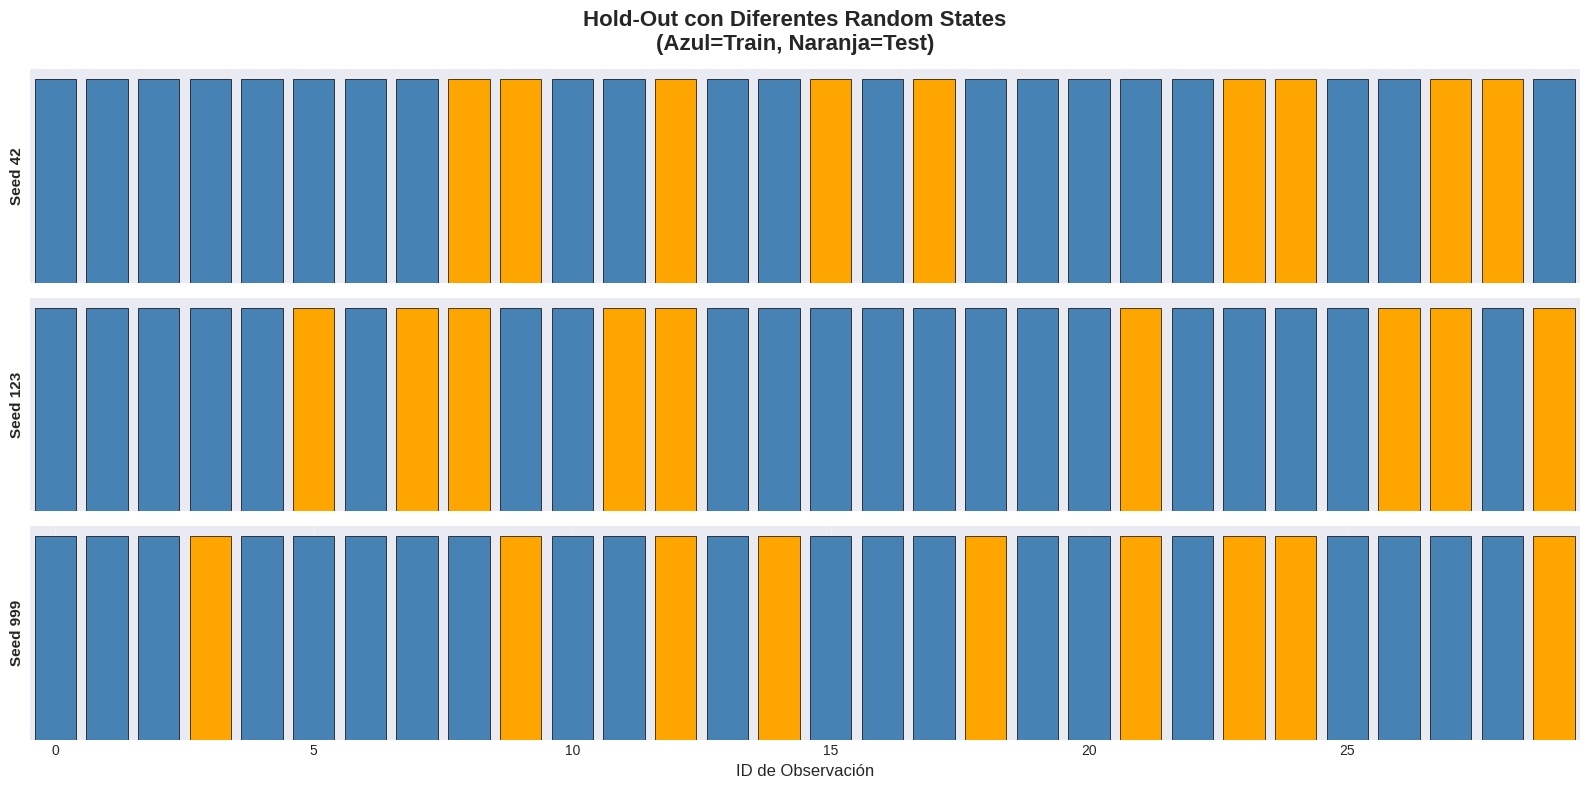

OBSERVACIÓN IMPORTANTE
• Diferentes random_state → diferentes particiones
• Esto introduce VARIABILIDAD en la evaluación
• Solución: k-Fold Cross-Validation


In [5]:
# Probar diferentes semillas
partitions = {}
for seed in [42, 123, 999]:
    train, test = train_test_split(
        np.arange(n_samples),
        test_size=0.3,
        random_state=seed
    )
    partitions[f'Seed {seed}'] = {'train': sorted(train.tolist()), 'test': sorted(test.tolist())}

# Visualización
fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for idx, (name, partition) in enumerate(partitions.items()):
    ax = axes[idx]

    colors = ['steelblue' if i in partition['train'] else 'orange' for i in range(n_samples)]
    ax.bar(range(n_samples), [1]*n_samples, color=colors, edgecolor='black', linewidth=0.5)
    ax.set_ylabel(name, fontsize=11, fontweight='bold')
    ax.set_yticks([])
    ax.set_xlim(-0.5, n_samples-0.5)
    ax.grid(alpha=0.3, axis='x')

    if idx == 2:
        ax.set_xlabel('ID de Observación', fontsize=12)
    else:
        ax.set_xticks([])

plt.suptitle('Hold-Out con Diferentes Random States\n(Azul=Train, Naranja=Test)',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("="*80)
print("OBSERVACIÓN IMPORTANTE")
print("="*80)
print("• Diferentes random_state → diferentes particiones")
print("• Esto introduce VARIABILIDAD en la evaluación")
print("• Solución: k-Fold Cross-Validation")

## 1.4 k-Fold Cross-Validation

Divide los datos en k subconjuntos (folds) y rota cuál es test.

K-FOLD CROSS-VALIDATION (k=5)

Total de observaciones: 30
Número de folds: 5
Tamaño aproximado de cada fold: 6

Fold 1:
  Train (24): [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 24, 25, 26, 28, 29]
  Test  (6): [8, 9, 15, 17, 23, 27]

Fold 2:
  Train (24): [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 29]
  Test  (6): [0, 4, 12, 16, 24, 28]

Fold 3:
  Train (24): [0, 3, 4, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29]
  Test  (6): [1, 2, 5, 11, 13, 22]

Fold 4:
  Train (24): [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 27, 28]
  Test  (6): [3, 18, 21, 25, 26, 29]

Fold 5:
  Train (24): [0, 1, 2, 3, 4, 5, 8, 9, 11, 12, 13, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29]
  Test  (6): [6, 7, 10, 14, 19, 20]


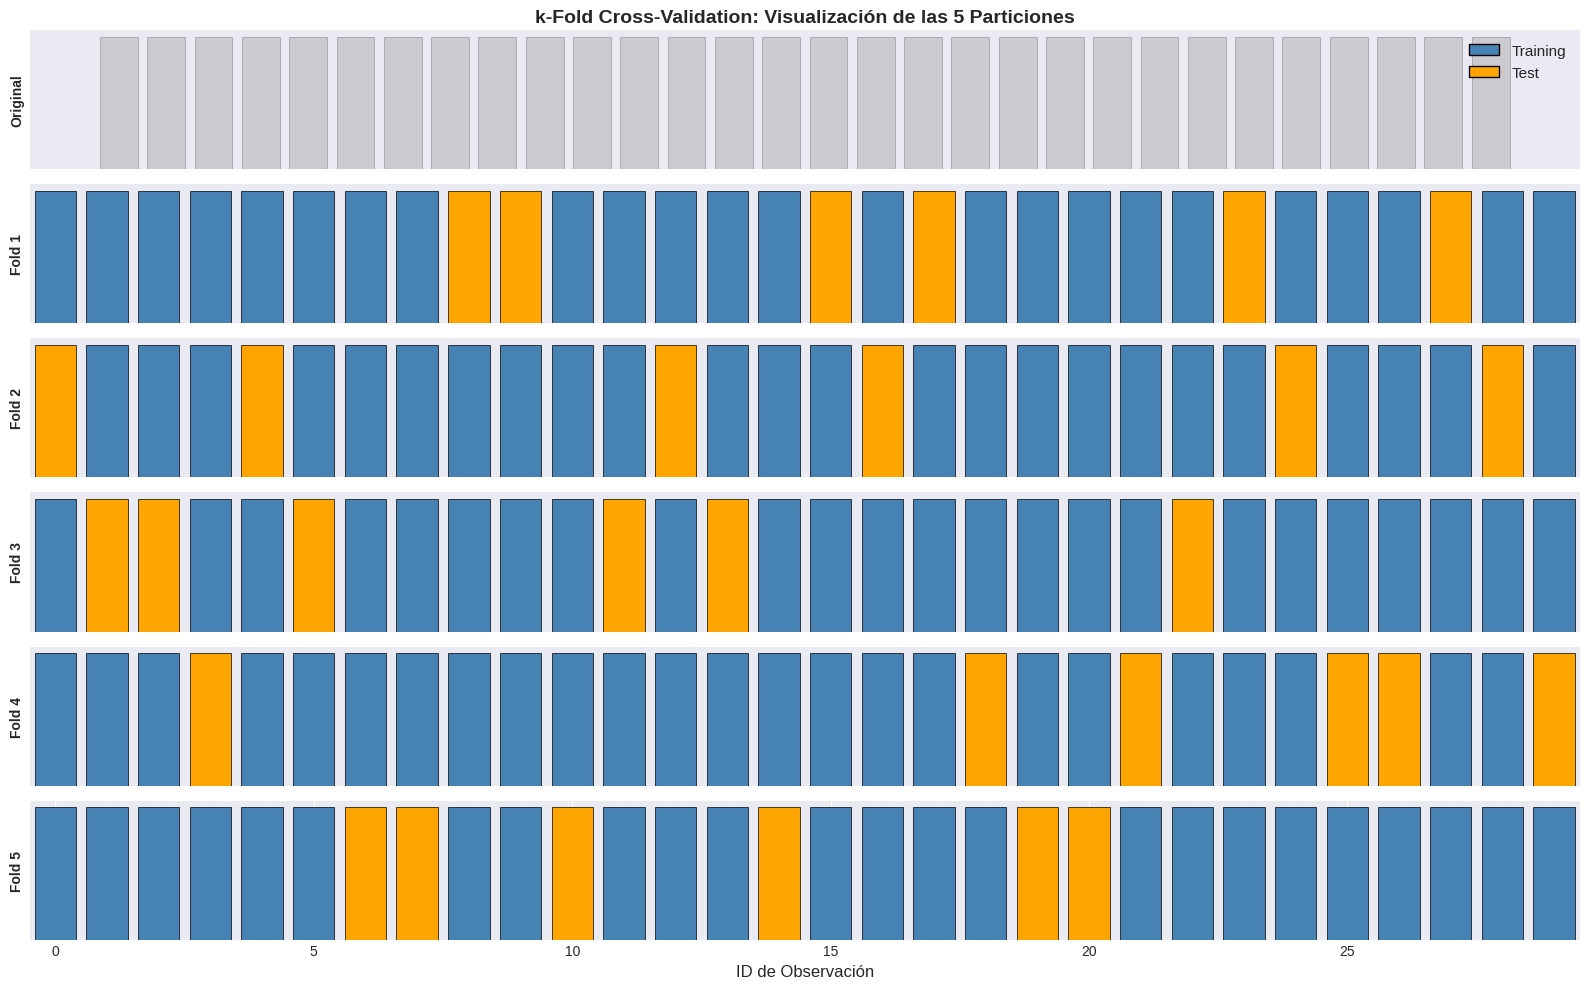


✓ Cada observación es test EXACTAMENTE 1 vez
✓ Cada observación es training EXACTAMENTE 4 veces


In [6]:
from sklearn.model_selection import KFold

# k-Fold con k=5
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("="*80)
print("K-FOLD CROSS-VALIDATION (k=5)")
print("="*80)
print(f"\nTotal de observaciones: {n_samples}")
print(f"Número de folds: 5")
print(f"Tamaño aproximado de cada fold: {n_samples//5}")

# Guardar información de cada fold
folds_info = []

for fold_idx, (train_indices, test_indices) in enumerate(kfold.split(X_visual), 1):
    train_list = sorted(train_indices.tolist())
    test_list = sorted(test_indices.tolist())

    folds_info.append({
        'fold': fold_idx,
        'train': train_list,
        'test': test_list,
        'train_size': len(train_list),
        'test_size': len(test_list)
    })

    print(f"\nFold {fold_idx}:")
    print(f"  Train ({len(train_list)}): {train_list}")
    print(f"  Test  ({len(test_list)}): {test_list}")

# Visualización de todos los folds
fig, axes = plt.subplots(6, 1, figsize=(16, 10))

# Primera fila: mostrar todas las observaciones
ax = axes[0]
ax.bar(range(n_samples), [1]*n_samples, color='gray', edgecolor='black', linewidth=0.5, alpha=0.3)
ax.set_ylabel('Original', fontsize=10, fontweight='bold')
ax.set_yticks([])
ax.set_title('k-Fold Cross-Validation: Visualización de las 5 Particiones',
            fontweight='bold', fontsize=14)
ax.set_xticks([])

# Siguientes filas: cada fold
for idx, fold_info in enumerate(folds_info):
    ax = axes[idx + 1]

    colors = ['steelblue' if i in fold_info['train'] else 'orange' for i in range(n_samples)]
    ax.bar(range(n_samples), [1]*n_samples, color=colors, edgecolor='black', linewidth=0.5)
    ax.set_ylabel(f"Fold {fold_info['fold']}", fontsize=10, fontweight='bold')
    ax.set_yticks([])
    ax.set_xlim(-0.5, n_samples-0.5)

    if idx == 4:  # Último fold
        ax.set_xlabel('ID de Observación', fontsize=12)
    else:
        ax.set_xticks([])

# Añadir leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='black', label='Training'),
    Patch(facecolor='orange', edgecolor='black', label='Test')
]
axes[0].legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n✓ Cada observación es test EXACTAMENTE 1 vez")
print(f"✓ Cada observación es training EXACTAMENTE {5-1} veces")

### Verificación: Cada observación aparece como test una sola vez

VERIFICACIÓN: Cobertura de k-Fold CV

Cada observación debe aparecer como test exactamente 1 vez:
  Mínimo: 1
  Máximo: 1
  Promedio: 1.0

✓ VERIFICADO: Todas las observaciones son test exactamente 1 vez


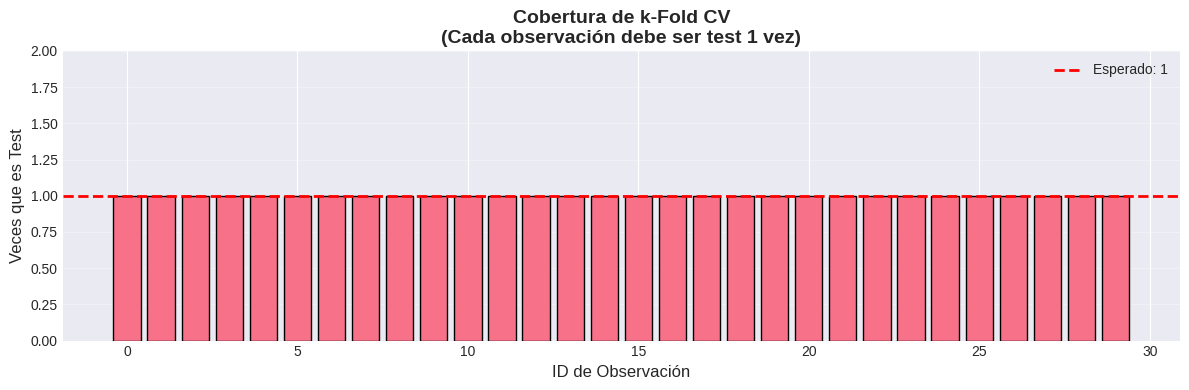

In [7]:
# Contar cuántas veces cada observación es test
test_count = np.zeros(n_samples, dtype=int)

for fold_info in folds_info:
    for idx in fold_info['test']:
        test_count[idx] += 1

# Verificación
print("="*80)
print("VERIFICACIÓN: Cobertura de k-Fold CV")
print("="*80)

print(f"\nCada observación debe aparecer como test exactamente 1 vez:")
print(f"  Mínimo: {test_count.min()}")
print(f"  Máximo: {test_count.max()}")
print(f"  Promedio: {test_count.mean():.1f}")

if np.all(test_count == 1):
    print(f"\n✓ VERIFICADO: Todas las observaciones son test exactamente 1 vez")
else:
    print(f"\n⚠️  ADVERTENCIA: Hay observaciones con conteo diferente de 1")

# Visualización de cobertura
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
bars = ax.bar(range(n_samples), test_count, edgecolor='black', linewidth=1)
ax.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Esperado: 1')
ax.set_xlabel('ID de Observación', fontsize=12)
ax.set_ylabel('Veces que es Test', fontsize=12)
ax.set_title('Cobertura de k-Fold CV\n(Cada observación debe ser test 1 vez)',
            fontweight='bold', fontsize=14)
ax.legend()
ax.grid(alpha=0.3, axis='y')
ax.set_ylim(0, 2)
plt.tight_layout()
plt.show()

## 1.5 Leave-One-Out Cross-Validation (LOOCV)

Caso extremo: k = n (cada observación es un fold).

LEAVE-ONE-OUT CROSS-VALIDATION

Observaciones: 10
Número de iteraciones: 10 (una por observación)

Primeras 5 iteraciones:
  Iter 1: Train=[1, 2, 3, 4, 5, 6, 7, 8, 9], Test=[0]
  Iter 2: Train=[0, 2, 3, 4, 5, 6, 7, 8, 9], Test=[1]
  Iter 3: Train=[0, 1, 3, 4, 5, 6, 7, 8, 9], Test=[2]
  Iter 4: Train=[0, 1, 2, 4, 5, 6, 7, 8, 9], Test=[3]
  Iter 5: Train=[0, 1, 2, 3, 5, 6, 7, 8, 9], Test=[4]
  ...


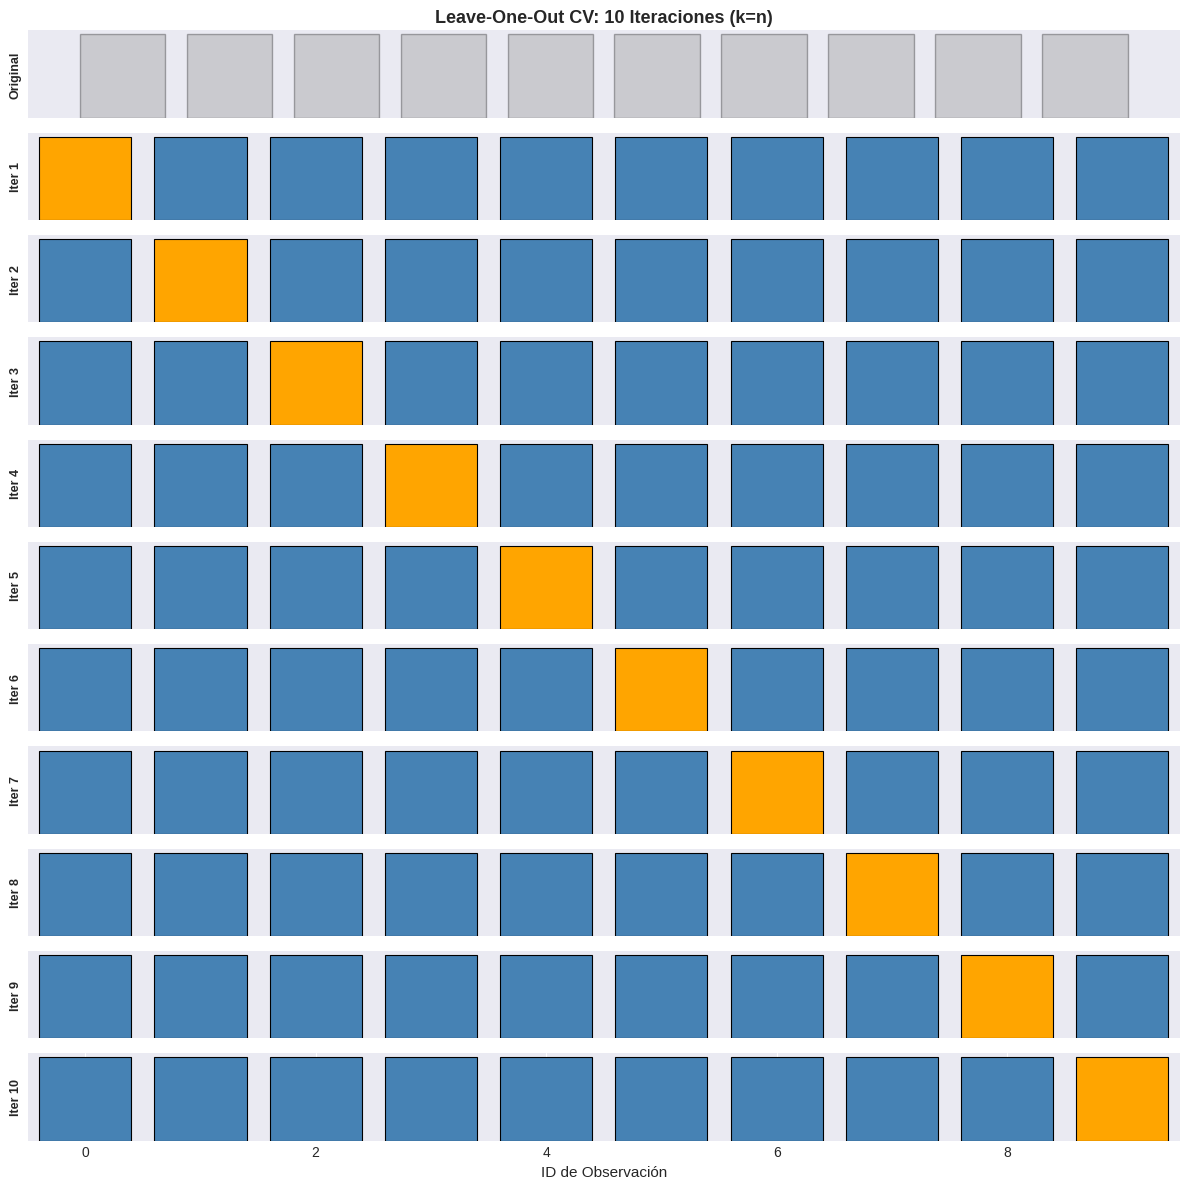


⚠️  LOOCV:
   • n iteraciones → muy costoso computacionalmente
   • Cada fold entrena con n-1 observaciones
   • Útil solo con datasets MUY pequeños
   • En la práctica, k-Fold (k=5 o k=10) es preferible


In [8]:
from sklearn.model_selection import LeaveOneOut

# LOOCV con dataset pequeño (10 observaciones para visualización)
n_small = 10
X_loocv = X_visual[:n_small]
y_loocv = y_visual[:n_small]

loo = LeaveOneOut()

print("="*80)
print("LEAVE-ONE-OUT CROSS-VALIDATION")
print("="*80)
print(f"\nObservaciones: {n_small}")
print(f"Número de iteraciones: {loo.get_n_splits(X_loocv)} (una por observación)")

# Mostrar primeras 5 iteraciones
print(f"\nPrimeras 5 iteraciones:")
for fold_idx, (train_indices, test_indices) in enumerate(loo.split(X_loocv), 1):
    if fold_idx > 5:
        break
    print(f"  Iter {fold_idx}: Train={sorted(train_indices.tolist())}, Test={test_indices.tolist()}")

print(f"  ...")

# Visualización de LOOCV
fig, axes = plt.subplots(11, 1, figsize=(12, 12))

# Primera fila: dataset original
ax = axes[0]
ax.bar(range(n_small), [1]*n_small, color='gray', edgecolor='black', alpha=0.3)
ax.set_ylabel('Original', fontsize=9, fontweight='bold')
ax.set_yticks([])
ax.set_title('Leave-One-Out CV: 10 Iteraciones (k=n)', fontweight='bold', fontsize=13)
ax.set_xticks([])

# Siguientes filas: cada iteración
for iter_idx, (train_indices, test_indices) in enumerate(loo.split(X_loocv), 1):
    ax = axes[iter_idx]

    colors = ['steelblue' if i in train_indices else 'orange' for i in range(n_small)]
    ax.bar(range(n_small), [1]*n_small, color=colors, edgecolor='black', linewidth=0.8)
    ax.set_ylabel(f'Iter {iter_idx}', fontsize=9, fontweight='bold')
    ax.set_yticks([])
    ax.set_xlim(-0.5, n_small-0.5)

    if iter_idx == n_small:
        ax.set_xlabel('ID de Observación', fontsize=11)
    else:
        ax.set_xticks([])

plt.tight_layout()
plt.show()

print(f"\n⚠️  LOOCV:")
print(f"   • n iteraciones → muy costoso computacionalmente")
print(f"   • Cada fold entrena con n-1 observaciones")
print(f"   • Útil solo con datasets MUY pequeños")
print(f"   • En la práctica, k-Fold (k=5 o k=10) es preferible")

## 1.6 Estratificación en Clasificación

Preservar las proporciones de clase en cada fold.

ESTRATIFICACIÓN EN CLASIFICACIÓN

Dataset desbalanceado:
  Clase 0: 21 (70.0%)
  Clase 1: 9 (30.0%)

K-FOLD SIN ESTRATIFICACIÓN
Fold 1:  33.3% clase 1 en test (2/6)
Fold 2:  33.3% clase 1 en test (2/6)
Fold 3:  16.7% clase 1 en test (1/6)
Fold 4:  66.7% clase 1 en test (4/6)
Fold 5:   0.0% clase 1 en test (0/6)

K-FOLD CON ESTRATIFICACIÓN
Fold 1:  16.7% clase 1 en test (1/6)
Fold 2:  33.3% clase 1 en test (2/6)
Fold 3:  33.3% clase 1 en test (2/6)
Fold 4:  33.3% clase 1 en test (2/6)
Fold 5:  33.3% clase 1 en test (2/6)


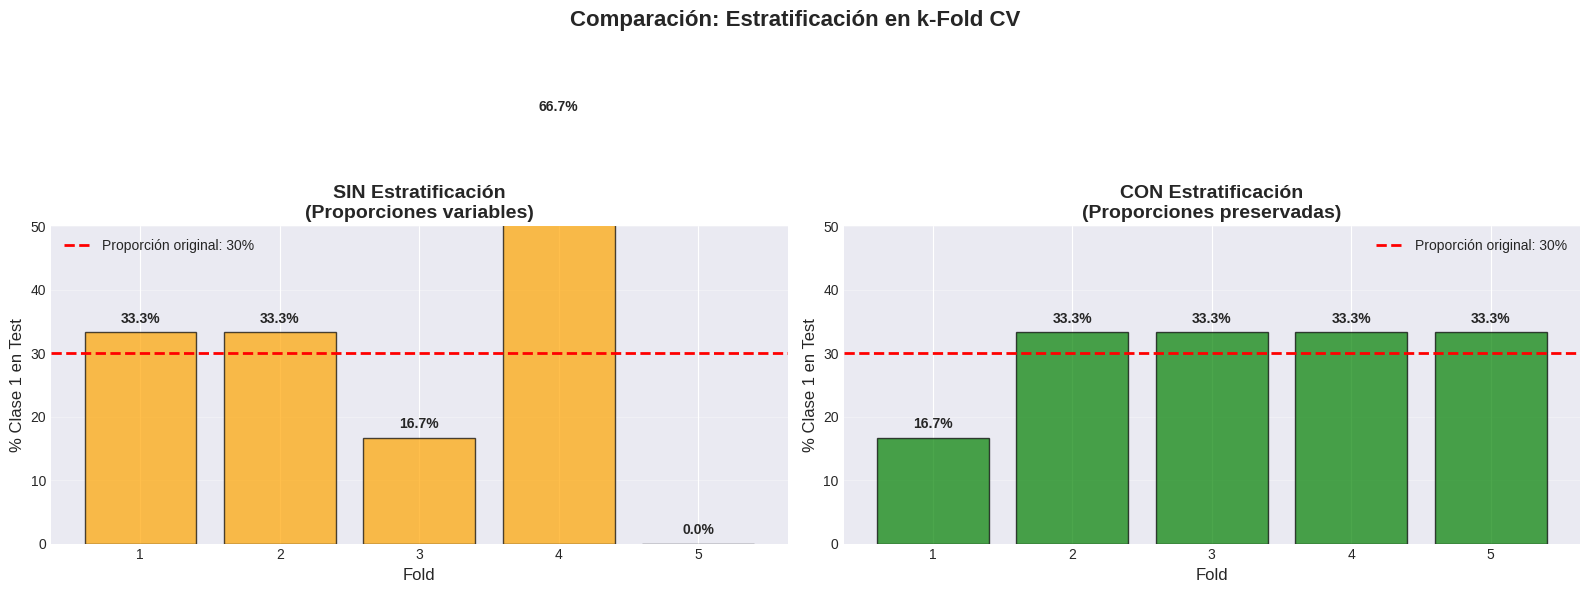


✓ Estratificación preserva las proporciones de clase en cada fold
✓ Esencial cuando hay desbalance de clases
✓ Reduce varianza en la estimación del desempeño


In [9]:
from sklearn.model_selection import StratifiedKFold

# Crear dataset pequeño DESBALANCEADO
np.random.seed(42)
n_strat = 30
y_desbal = np.array([0]*21 + [1]*9)  # 70% clase 0, 30% clase 1
X_strat = np.random.randn(n_strat, 3)

print("="*80)
print("ESTRATIFICACIÓN EN CLASIFICACIÓN")
print("="*80)

print(f"\nDataset desbalanceado:")
unique, counts = np.unique(y_desbal, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Clase {cls}: {count} ({100*count/len(y_desbal):.1f}%)")

# k-Fold SIN estratificación
print(f"\n{'='*80}")
print("K-FOLD SIN ESTRATIFICACIÓN")
print(f"{'='*80}")

kfold_no_strat = KFold(n_splits=5, shuffle=True, random_state=42)

test_class_dist_no_strat = []
for fold_idx, (train_idx, test_idx) in enumerate(kfold_no_strat.split(X_strat), 1):
    y_test = y_desbal[test_idx]
    class_1_count = (y_test == 1).sum()
    class_1_pct = 100 * class_1_count / len(y_test)
    test_class_dist_no_strat.append(class_1_pct)
    print(f"Fold {fold_idx}: {class_1_pct:5.1f}% clase 1 en test ({class_1_count}/{len(y_test)})")

# k-Fold CON estratificación
print(f"\n{'='*80}")
print("K-FOLD CON ESTRATIFICACIÓN")
print(f"{'='*80}")

kfold_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

test_class_dist_strat = []
for fold_idx, (train_idx, test_idx) in enumerate(kfold_strat.split(X_strat, y_desbal), 1):
    y_test = y_desbal[test_idx]
    class_1_count = (y_test == 1).sum()
    class_1_pct = 100 * class_1_count / len(y_test)
    test_class_dist_strat.append(class_1_pct)
    print(f"Fold {fold_idx}: {class_1_pct:5.1f}% clase 1 en test ({class_1_count}/{len(y_test)})")

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sin estratificación
ax = axes[0]
folds = np.arange(1, 6)
bars = ax.bar(folds, test_class_dist_no_strat, alpha=0.7, color='orange', edgecolor='black')
ax.axhline(30, color='red', linestyle='--', linewidth=2, label='Proporción original: 30%')
ax.set_xlabel('Fold', fontsize=12)
ax.set_ylabel('% Clase 1 en Test', fontsize=12)
ax.set_title('SIN Estratificación\n(Proporciones variables)', fontweight='bold', fontsize=14)
ax.set_ylim(0, 50)
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Añadir valores
for bar, val in zip(bars, test_class_dist_no_strat):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
           f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Con estratificación
ax = axes[1]
bars = ax.bar(folds, test_class_dist_strat, alpha=0.7, color='green', edgecolor='black')
ax.axhline(30, color='red', linestyle='--', linewidth=2, label='Proporción original: 30%')
ax.set_xlabel('Fold', fontsize=12)
ax.set_ylabel('% Clase 1 en Test', fontsize=12)
ax.set_title('CON Estratificación\n(Proporciones preservadas)', fontweight='bold', fontsize=14)
ax.set_ylim(0, 50)
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Añadir valores
for bar, val in zip(bars, test_class_dist_strat):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
           f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Comparación: Estratificación en k-Fold CV', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Estratificación preserva las proporciones de clase en cada fold")
print(f"✓ Esencial cuando hay desbalance de clases")
print(f"✓ Reduce varianza en la estimación del desempeño")

---
# Parte 2: Evaluación de Modelos de Regresión

Métricas para problemas donde la variable objetivo es continua.

## 2.1 Dataset: Diabetes

Usaremos el dataset clásico de diabetes para predecir progresión de la enfermedad.

In [10]:
# Cargar dataset
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target

print("="*80)
print("DATASET: Diabetes")
print("="*80)
print(f"\nObservaciones: {X_diabetes.shape[0]}")
print(f"Features: {X_diabetes.shape[1]}")
print(f"\nVariable objetivo: Progresión de diabetes (continua)")
print(f"  Min: {y_diabetes.min():.1f}")
print(f"  Max: {y_diabetes.max():.1f}")
print(f"  Media: {y_diabetes.mean():.1f}")
print(f"  Std: {y_diabetes.std():.1f}")

# Partición
X_train_diab, X_test_diab, y_train_diab, y_test_diab = train_test_split(
    X_diabetes, y_diabetes, test_size=0.3, random_state=42
)

print(f"\nPartición 70-30:")
print(f"  Training: {len(X_train_diab)}")
print(f"  Test: {len(X_test_diab)}")

DATASET: Diabetes

Observaciones: 442
Features: 10

Variable objetivo: Progresión de diabetes (continua)
  Min: 25.0
  Max: 346.0
  Media: 152.1
  Std: 77.0

Partición 70-30:
  Training: 309
  Test: 133


## 2.2 Métricas de Regresión

Compararemos MAE, MSE, RMSE y R² en diferentes modelos.

In [11]:
def evaluate_regression_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evalúa un modelo de regresión con múltiples métricas
    """
    # Entrenar
    model.fit(X_train, y_train)

    # Predecir
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcular métricas
    metrics = {
        'Model': model_name,
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train R²': r2_score(y_train, y_train_pred),
        'Test R²': r2_score(y_test, y_test_pred)
    }

    return metrics, y_test_pred

# Modelos a comparar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
    'KNN (k=5)': KNeighborsRegressor(n_neighbors=5)
}

results = []
predictions = {}

print("="*80)
print("COMPARACIÓN DE MODELOS - REGRESIÓN")
print("="*80)

for name, model in models.items():
    metrics, y_pred = evaluate_regression_model(
        model, X_train_diab, X_test_diab, y_train_diab, y_test_diab, name
    )
    results.append(metrics)
    predictions[name] = y_pred
    print(f"✓ {name}")

df_results_reg = pd.DataFrame(results)
print(f"\n{df_results_reg.to_string(index=False)}")

COMPARACIÓN DE MODELOS - REGRESIÓN
✓ Linear Regression
✓ Ridge (α=1.0)
✓ Decision Tree
✓ Random Forest
✓ KNN (k=5)

            Model  Train MAE  Test MAE   Train MSE    Test MSE  Train RMSE  Test RMSE  Train R²  Test R²
Linear Regression  44.097835 41.919378 2924.046379 2821.750981   54.074452  53.120156  0.524412 0.477290
    Ridge (α=1.0)  50.271435 45.463528 3514.861055 3112.966415   59.286264  55.793964  0.428318 0.423344
    Decision Tree  33.320504 48.569336 1965.719123 3818.071494   44.336431  61.790545  0.680282 0.292728
    Random Forest  32.965160 42.272419 1562.972990 2782.442880   39.534453  52.748866  0.745787 0.484571
        KNN (k=5)  41.074434 44.003008 2627.170744 3222.117895   51.255934  56.763702  0.572698 0.403124


### Visualización de Resultados

Comparemos las métricas y las predicciones.

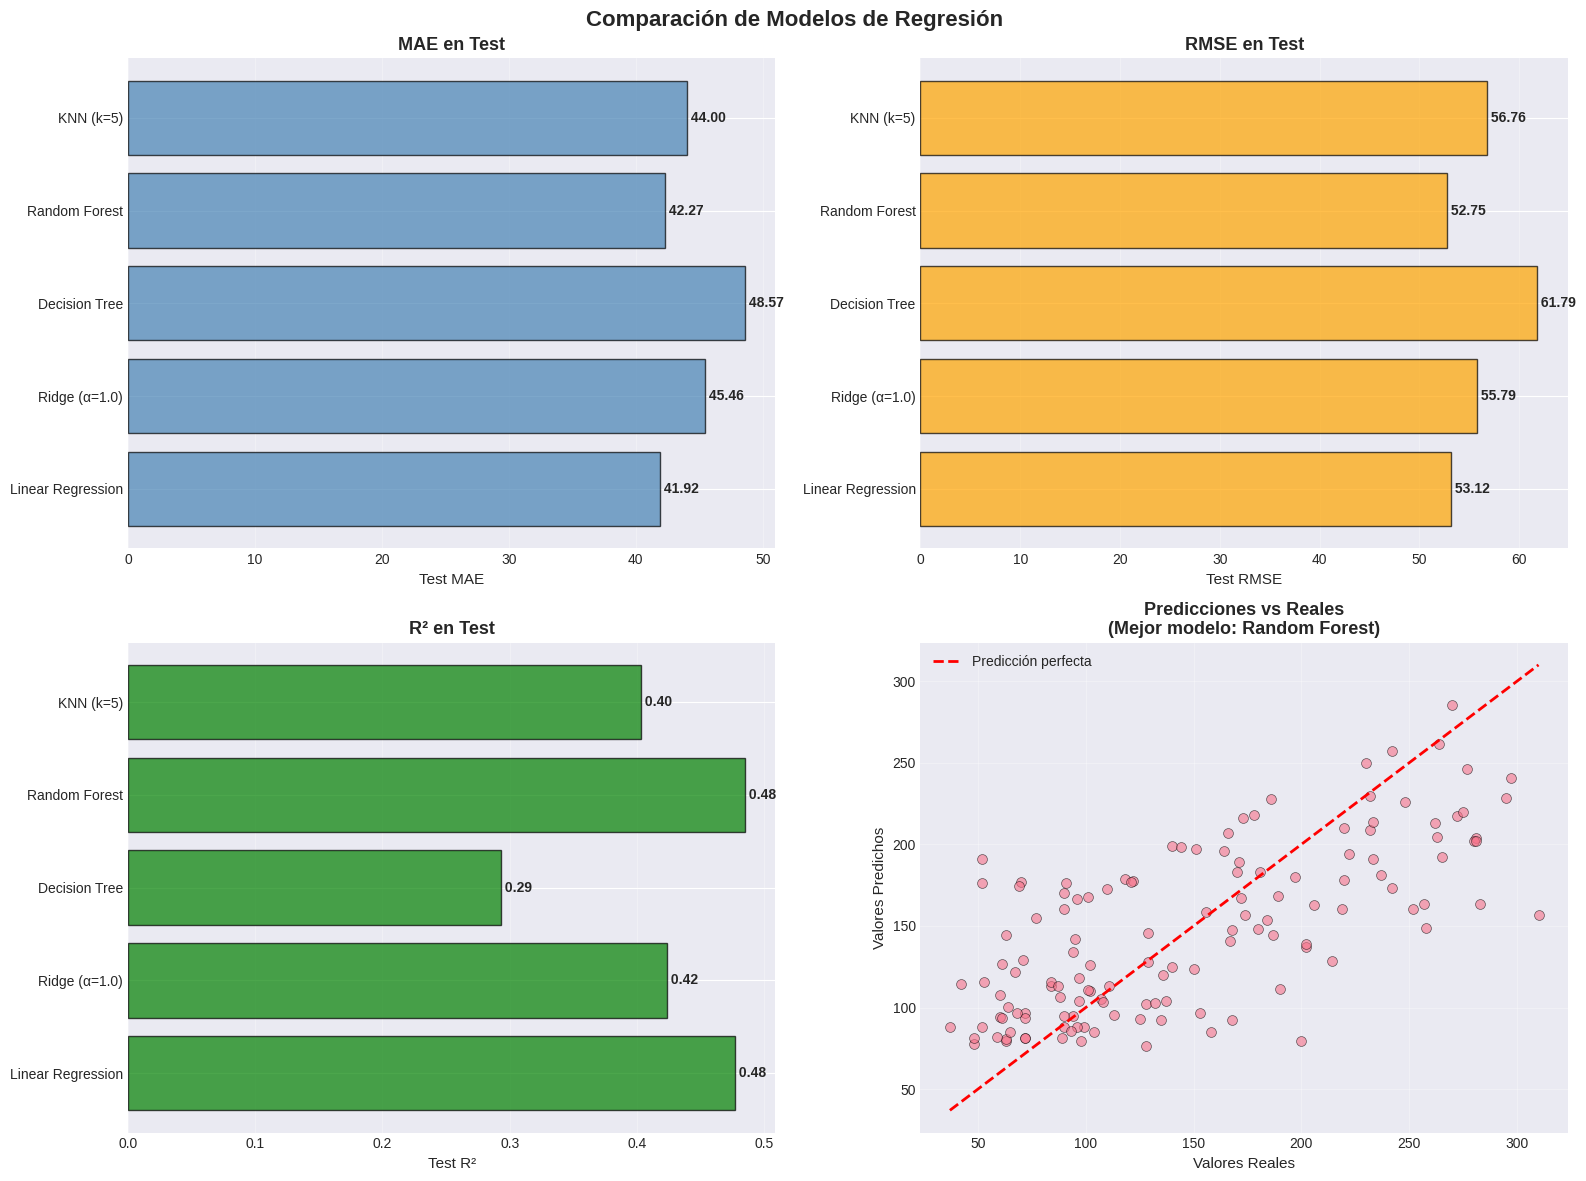


🏆 Mejor modelo por R²: Random Forest
   Test R²: 0.485


In [12]:
# Visualización de métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = [
    ('Test MAE', 'MAE en Test', 'steelblue'),
    ('Test RMSE', 'RMSE en Test', 'orange'),
    ('Test R²', 'R² en Test', 'green'),
]

for idx, (metric, title, color) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]

    values = df_results_reg[metric].values
    models_names = df_results_reg['Model'].values

    bars = ax.barh(models_names, values, color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(title, fontweight='bold', fontsize=13)
    ax.grid(alpha=0.3, axis='x')

    # Añadir valores
    for bar, val in zip(bars, values):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
               f' {val:.2f}', ha='left', va='center', fontsize=10, fontweight='bold')

# Predicciones vs Real (mejor modelo por R²)
ax = axes[1, 1]
best_model_name = df_results_reg.loc[df_results_reg['Test R²'].idxmax(), 'Model']
y_pred_best = predictions[best_model_name]

ax.scatter(y_test_diab, y_pred_best, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax.plot([y_test_diab.min(), y_test_diab.max()],
        [y_test_diab.min(), y_test_diab.max()],
        'r--', linewidth=2, label='Predicción perfecta')
ax.set_xlabel('Valores Reales', fontsize=11)
ax.set_ylabel('Valores Predichos', fontsize=11)
ax.set_title(f'Predicciones vs Reales\n(Mejor modelo: {best_model_name})', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(alpha=0.3)

plt.suptitle('Comparación de Modelos de Regresión', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n🏆 Mejor modelo por R²: {best_model_name}")
print(f"   Test R²: {df_results_reg.loc[df_results_reg['Test R²'].idxmax(), 'Test R²']:.3f}")

## 2.3 Análisis de Residuos

Los residuos revelan patrones de error del modelo.

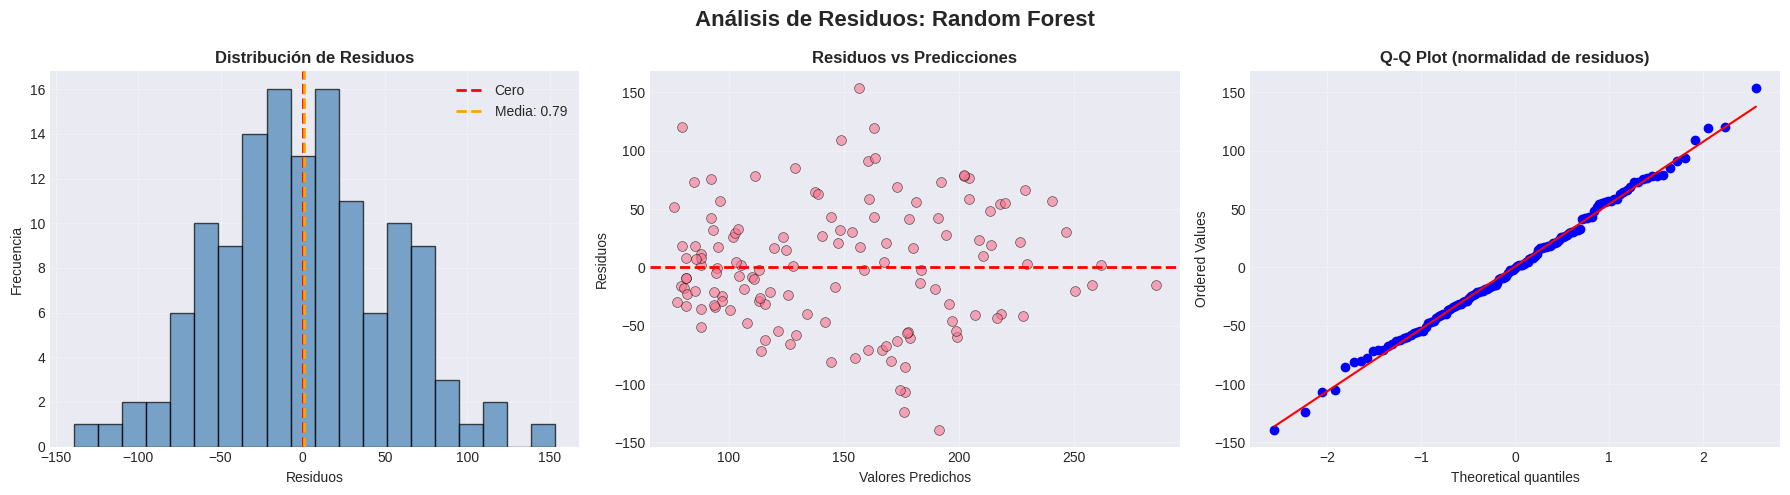

Estadísticas de residuos:
  Media: 0.79 (debe estar cerca de 0)
  Std: 52.74
  Min: -139.03
  Max: 153.48


In [13]:
# Análisis de residuos del mejor modelo
best_model_idx = df_results_reg['Test R²'].idxmax()
best_model_name = df_results_reg.loc[best_model_idx, 'Model']
y_pred_best = predictions[best_model_name]

residuals = y_test_diab - y_pred_best

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribución de residuos
ax = axes[0]
ax.hist(residuals, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Cero')
ax.axvline(residuals.mean(), color='orange', linestyle='--', linewidth=2, label=f'Media: {residuals.mean():.2f}')
ax.set_xlabel('Residuos')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Residuos', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Residuos vs Predicciones
ax = axes[1]
ax.scatter(y_pred_best, residuals, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Valores Predichos')
ax.set_ylabel('Residuos')
ax.set_title('Residuos vs Predicciones', fontweight='bold')
ax.grid(alpha=0.3)

# Q-Q plot
ax = axes[2]
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title('Q-Q Plot (normalidad de residuos)', fontweight='bold')
ax.grid(alpha=0.3)

plt.suptitle(f'Análisis de Residuos: {best_model_name}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Estadísticas de residuos:")
print(f"  Media: {residuals.mean():.2f} (debe estar cerca de 0)")
print(f"  Std: {residuals.std():.2f}")
print(f"  Min: {residuals.min():.2f}")
print(f"  Max: {residuals.max():.2f}")

---
# Parte 3: Evaluación de Modelos de Clasificación

Métricas para problemas donde la variable objetivo es categórica.

## 3.1 Dataset: Breast Cancer

Usaremos el dataset Wisconsin Breast Cancer (clasificación binaria).

In [14]:
# Cargar dataset
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

print("="*80)
print("DATASET: Wisconsin Breast Cancer")
print("="*80)
print(f"\nObservaciones: {X_cancer.shape[0]}")
print(f"Features: {X_cancer.shape[1]}")
print(f"\nClases:")
unique, counts = np.unique(y_cancer, return_counts=True)
for cls, count, name in zip(unique, counts, cancer.target_names):
    print(f"  {cls} ({name}): {count} ({100*count/len(y_cancer):.1f}%)")

# Partición estratificada
X_train_canc, X_test_canc, y_train_canc, y_test_canc = train_test_split(
    X_cancer, y_cancer, test_size=0.3, random_state=42, stratify=y_cancer
)

print(f"\nPartición estratificada 70-30:")
print(f"  Training: {len(X_train_canc)}")
print(f"  Test: {len(X_test_canc)}")

# Verificar estratificación
print(f"\nDistribución en test:")
unique, counts = np.unique(y_test_canc, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Clase {cls}: {count} ({100*count/len(y_test_canc):.1f}%)")

DATASET: Wisconsin Breast Cancer

Observaciones: 569
Features: 30

Clases:
  0 (malignant): 212 (37.3%)
  1 (benign): 357 (62.7%)

Partición estratificada 70-30:
  Training: 398
  Test: 171

Distribución en test:
  Clase 0: 64 (37.4%)
  Clase 1: 107 (62.6%)


## 3.2 Matriz de Confusión

La base para todas las métricas de clasificación.

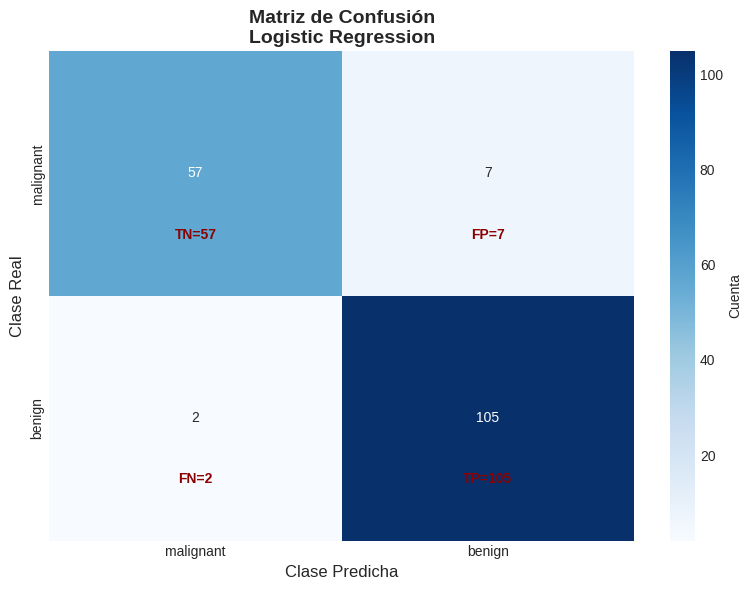

MÉTRICAS DESDE LA MATRIZ DE CONFUSIÓN

Verdaderos Negativos (TN): 57
Falsos Positivos (FP):     7  ← Error Tipo I
Falsos Negativos (FN):     2  ← Error Tipo II
Verdaderos Positivos (TP): 105


In [15]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """
    Visualiza la matriz de confusión
    """
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Cuenta'}, ax=ax)

    ax.set_ylabel('Clase Real', fontsize=12)
    ax.set_xlabel('Clase Predicha', fontsize=12)
    ax.set_title(f'Matriz de Confusión\n{model_name}', fontweight='bold', fontsize=14)

    # Añadir anotaciones TN, FP, FN, TP
    tn, fp, fn, tp = cm.ravel()
    annotations = [
        (0, 0, f'TN={tn}'),
        (1, 0, f'FP={fp}'),
        (0, 1, f'FN={fn}'),
        (1, 1, f'TP={tp}')
    ]

    for x, y, text in annotations:
        ax.text(x + 0.5, y + 0.75, text, ha='center', va='center',
               fontsize=10, color='darkred', fontweight='bold')

    plt.tight_layout()
    return fig, cm

# Entrenar modelo simple
model_lr = LogisticRegression(max_iter=10000, random_state=42)
model_lr.fit(X_train_canc, y_train_canc)
y_pred_lr = model_lr.predict(X_test_canc)

# Matriz de confusión
fig_cm, cm = plot_confusion_matrix(y_test_canc, y_pred_lr, cancer.target_names, 'Logistic Regression')
plt.show()

# Métricas básicas
tn, fp, fn, tp = cm.ravel()
print("="*80)
print("MÉTRICAS DESDE LA MATRIZ DE CONFUSIÓN")
print("="*80)
print(f"\nVerdaderos Negativos (TN): {tn}")
print(f"Falsos Positivos (FP):     {fp}  ← Error Tipo I")
print(f"Falsos Negativos (FN):     {fn}  ← Error Tipo II")
print(f"Verdaderos Positivos (TP): {tp}")

## 3.3 Métricas de Clasificación

Calculemos todas las métricas principales.

In [16]:
def calculate_classification_metrics(y_true, y_pred, y_pred_proba=None):
    """
    Calcula todas las métricas de clasificación
    """
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred)
    }

    if y_pred_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred_proba)

    return metrics

# Métricas para Logistic Regression
y_pred_proba_lr = model_lr.predict_proba(X_test_canc)[:, 1]
metrics_lr = calculate_classification_metrics(y_test_canc, y_pred_lr, y_pred_proba_lr)

print("="*80)
print("MÉTRICAS DE CLASIFICACIÓN - Logistic Regression")
print("="*80)

for metric, value in metrics_lr.items():
    print(f"{metric:15s}: {value:.4f}")

print(f"\nInterpretación:")
print(f"  • Accuracy:  {metrics_lr['Accuracy']:.1%} de predicciones correctas")
print(f"  • Precision: {metrics_lr['Precision']:.1%} de positivos predichos son correctos")
print(f"  • Recall:    {metrics_lr['Recall']:.1%} de positivos reales fueron detectados")
print(f"  • F1-Score:  Media armónica de Precision y Recall")
print(f"  • MCC:       Correlación entre predicción y realidad [-1, 1]")
print(f"  • ROC-AUC:   Área bajo la curva ROC [0.5, 1.0]")

MÉTRICAS DE CLASIFICACIÓN - Logistic Regression
Accuracy       : 0.9474
Precision      : 0.9375
Recall         : 0.9813
F1-Score       : 0.9589
MCC            : 0.8876
ROC-AUC        : 0.9889

Interpretación:
  • Accuracy:  94.7% de predicciones correctas
  • Precision: 93.8% de positivos predichos son correctos
  • Recall:    98.1% de positivos reales fueron detectados
  • F1-Score:  Media armónica de Precision y Recall
  • MCC:       Correlación entre predicción y realidad [-1, 1]
  • ROC-AUC:   Área bajo la curva ROC [0.5, 1.0]


## 3.4 Curva ROC y AUC

La curva ROC evalúa el desempeño variando el umbral de clasificación.

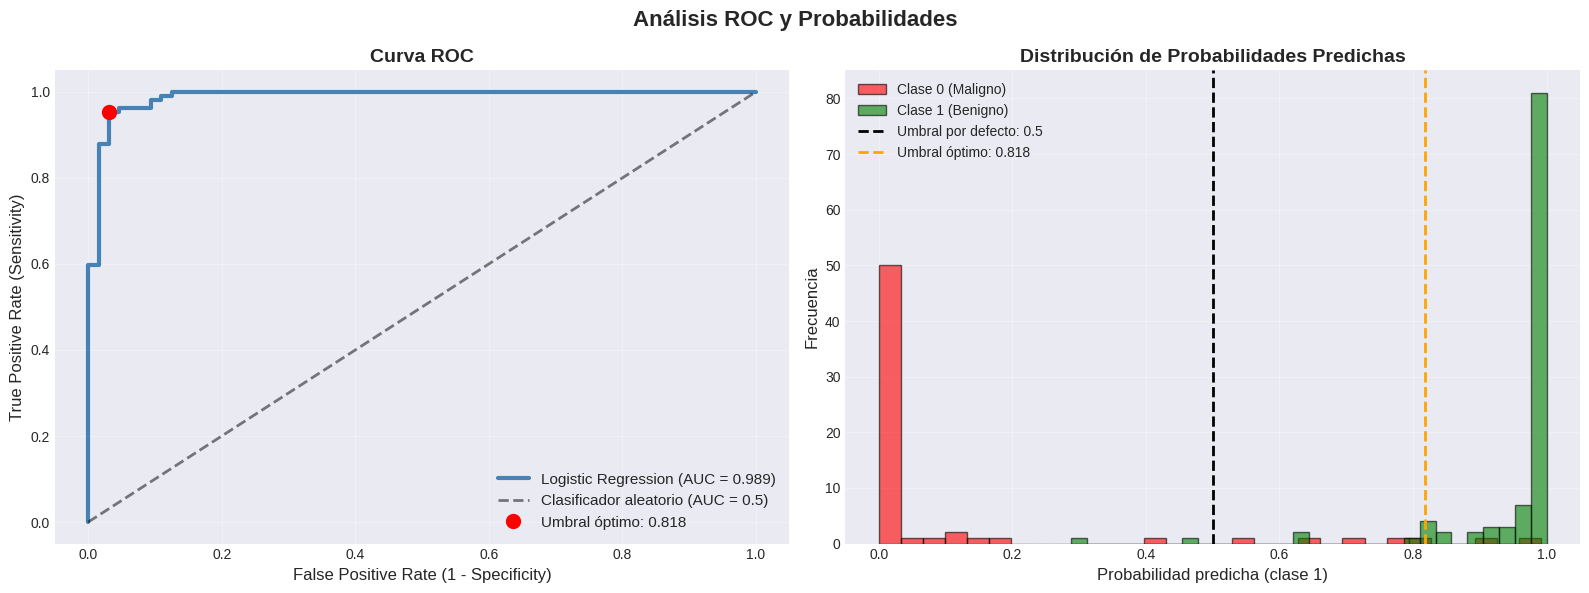

ROC-AUC: 0.9889
Interpretación: Probabilidad de que el modelo asigne mayor score a un
                positivo real que a un negativo real

Umbral óptimo: 0.818 (vs 0.5 por defecto)


In [17]:
# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test_canc, y_pred_proba_lr)
roc_auc = roc_auc_score(y_test_canc, y_pred_proba_lr)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Curva ROC
ax = axes[0]
ax.plot(fpr, tpr, linewidth=3, label=f'Logistic Regression (AUC = {roc_auc:.3f})', color='steelblue')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Clasificador aleatorio (AUC = 0.5)', alpha=0.5)
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
ax.set_title('Curva ROC', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

# Umbral óptimo
# Criterio: maximizar TPR - FPR
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
ax.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10,
        label=f'Umbral óptimo: {optimal_threshold:.3f}')
ax.legend(fontsize=11)

# Distribución de probabilidades
ax = axes[1]
y_pred_proba_class0 = y_pred_proba_lr[y_test_canc == 0]
y_pred_proba_class1 = y_pred_proba_lr[y_test_canc == 1]

ax.hist(y_pred_proba_class0, bins=30, alpha=0.6, color='red', label='Clase 0 (Maligno)', edgecolor='black')
ax.hist(y_pred_proba_class1, bins=30, alpha=0.6, color='green', label='Clase 1 (Benigno)', edgecolor='black')
ax.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Umbral por defecto: 0.5')
ax.axvline(optimal_threshold, color='orange', linestyle='--', linewidth=2, label=f'Umbral óptimo: {optimal_threshold:.3f}')
ax.set_xlabel('Probabilidad predicha (clase 1)', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.set_title('Distribución de Probabilidades Predichas', fontweight='bold', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.suptitle('Análisis ROC y Probabilidades', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Interpretación: Probabilidad de que el modelo asigne mayor score a un")
print(f"                positivo real que a un negativo real")
print(f"\nUmbral óptimo: {optimal_threshold:.3f} (vs 0.5 por defecto)")

## 3.5 Comparación de Múltiples Modelos

Evaluemos diferentes clasificadores.

In [18]:
def evaluate_classifier(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evalúa un modelo de clasificación con todas las métricas
    """
    # Entrenar
    model.fit(X_train, y_train)

    # Predecir
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Métricas
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }

    if y_pred_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_test, y_pred_proba)
    else:
        metrics['ROC-AUC'] = np.nan

    return metrics, y_pred, y_pred_proba

# Modelos a comparar
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'SVM (linear)': SVC(kernel='linear', probability=True, random_state=42)
}

results_class = []
predictions_class = {}
probas_class = {}

print("="*80)
print("COMPARACIÓN DE CLASIFICADORES")
print("="*80)

for name, model in classifiers.items():
    metrics, y_pred, y_proba = evaluate_classifier(
        model, X_train_canc, X_test_canc, y_train_canc, y_test_canc, name
    )
    results_class.append(metrics)
    predictions_class[name] = y_pred
    probas_class[name] = y_proba
    print(f"✓ {name}")

df_results_class = pd.DataFrame(results_class)
print(f"\n{df_results_class.to_string(index=False)}")

# Identificar mejor modelo
best_f1_idx = df_results_class['F1-Score'].idxmax()
best_model_name = df_results_class.loc[best_f1_idx, 'Model']
print(f"\n🏆 Mejor modelo por F1-Score: {best_model_name}")
print(f"   F1-Score: {df_results_class.loc[best_f1_idx, 'F1-Score']:.4f}")

COMPARACIÓN DE CLASIFICADORES
✓ Logistic Regression
✓ Decision Tree
✓ Random Forest
✓ KNN (k=5)
✓ SVM (linear)

              Model  Accuracy  Precision   Recall  F1-Score      MCC  ROC-AUC
Logistic Regression  0.947368   0.937500 0.981308  0.958904 0.887626 0.988902
      Decision Tree  0.929825   0.943925 0.943925  0.943925 0.850175 0.944144
      Random Forest  0.941520   0.944954 0.962617  0.953704 0.874633 0.989340
          KNN (k=5)  0.923977   0.935185 0.943925  0.939535 0.837244 0.948890
       SVM (linear)  0.953216   0.938053 0.990654  0.963636 0.900829 0.986711

🏆 Mejor modelo por F1-Score: SVM (linear)
   F1-Score: 0.9636


### Visualización Comparativa

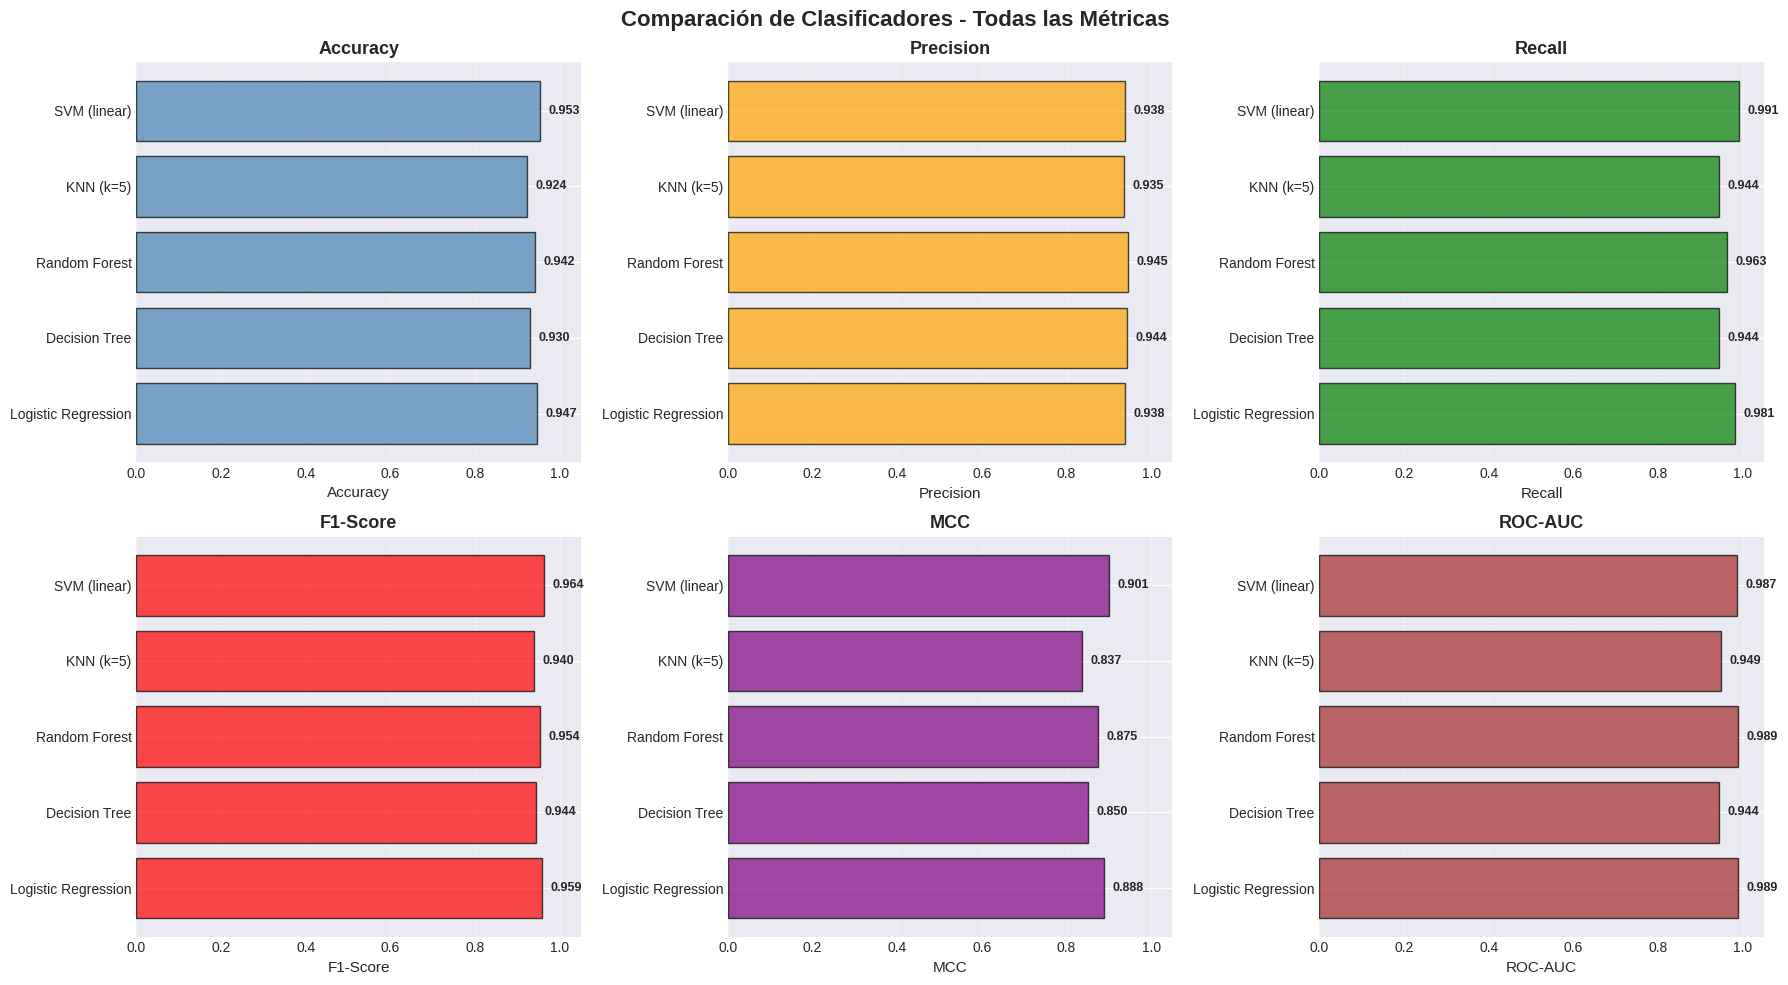

In [19]:
# Visualización de métricas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC', 'ROC-AUC']
colors = ['steelblue', 'orange', 'green', 'red', 'purple', 'brown']

for idx, (metric, color) in enumerate(zip(metrics_names, colors)):
    ax = axes[idx]

    values = df_results_class[metric].values
    models = df_results_class['Model'].values

    bars = ax.barh(models, values, color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(metric, fontweight='bold', fontsize=13)
    ax.grid(alpha=0.3, axis='x')
    ax.set_xlim(0, 1.05)

    # Añadir valores
    for bar, val in zip(bars, values):
        if not np.isnan(val):
            width = bar.get_width()
            ax.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                   f'{val:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')

plt.suptitle('Comparación de Clasificadores - Todas las Métricas',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Parte 4: Mejores Prácticas en Validación

Cómo evitar errores comunes y obtener evaluaciones confiables.

## 4.1 Data Leakage: El Enemigo Silencioso

La fuga de información invalida la evaluación.

In [20]:
print("="*80)
print("EJEMPLO DE DATA LEAKAGE")
print("="*80)

# Crear dataset simple
X_leak, y_leak = make_classification(n_samples=200, n_features=10, random_state=42)

print(f"\n--- INCORRECTO: Escalar antes de dividir ---")
# ❌ MAL: Escalar con todo el dataset
scaler_wrong = StandardScaler()
X_scaled_wrong = scaler_wrong.fit_transform(X_leak)

# Luego dividir
X_train_wrong, X_test_wrong, y_train_wrong, y_test_wrong = train_test_split(
    X_scaled_wrong, y_leak, test_size=0.3, random_state=42
)

# Entrenar y evaluar
model_wrong = LogisticRegression(max_iter=1000)
model_wrong.fit(X_train_wrong, y_train_wrong)
acc_wrong = model_wrong.score(X_test_wrong, y_test_wrong)

print(f"Accuracy (con leakage): {acc_wrong:.4f}")
print(f"⚠️  El scaler vio TODO el dataset → información del test filtró al train")

print(f"\n--- CORRECTO: Escalar solo con training ---")
# ✅ BIEN: Primero dividir
X_train_right, X_test_right, y_train_right, y_test_right = train_test_split(
    X_leak, y_leak, test_size=0.3, random_state=42
)

# Luego escalar solo con training
scaler_right = StandardScaler()
X_train_scaled = scaler_right.fit_transform(X_train_right)
X_test_scaled = scaler_right.transform(X_test_right)  # Solo transform, NO fit_transform

# Entrenar y evaluar
model_right = LogisticRegression(max_iter=1000)
model_right.fit(X_train_scaled, y_train_right)
acc_right = model_right.score(X_test_scaled, y_test_right)

print(f"Accuracy (sin leakage): {acc_right:.4f}")
print(f"✓ El scaler solo vio training → evaluación válida")

print(f"\nDiferencia: {acc_wrong - acc_right:.4f}")
print(f"La evaluación con leakage es artificialmente optimista!")

EJEMPLO DE DATA LEAKAGE

--- INCORRECTO: Escalar antes de dividir ---
Accuracy (con leakage): 0.7167
⚠️  El scaler vio TODO el dataset → información del test filtró al train

--- CORRECTO: Escalar solo con training ---
Accuracy (sin leakage): 0.7167
✓ El scaler solo vio training → evaluación válida

Diferencia: 0.0000
La evaluación con leakage es artificialmente optimista!


## 4.2 Usando Pipelines para Evitar Leakage

Los pipelines automatizan el flujo correcto.

In [21]:
from sklearn.pipeline import Pipeline

# Pipeline correcto
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Cross-validation con pipeline
cv_scores = cross_val_score(pipeline, X_leak, y_leak, cv=5, scoring='accuracy')

print("="*80)
print("PIPELINE + CROSS-VALIDATION")
print("="*80)
print(f"\nAccuracy por fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMedia: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"\n✓ El pipeline garantiza que el escalamiento se hace DENTRO de cada fold")
print(f"✓ No hay leakage entre training y test en ningún fold")

PIPELINE + CROSS-VALIDATION

Accuracy por fold:
  Fold 1: 0.8500
  Fold 2: 0.8750
  Fold 3: 0.7750
  Fold 4: 0.8000
  Fold 5: 0.9000

Media: 0.8400 ± 0.0464

✓ El pipeline garantiza que el escalamiento se hace DENTRO de cada fold
✓ No hay leakage entre training y test en ningún fold


## 4.3 Selección de Métricas Según Contexto

No existe una métrica universalmente superior.

In [22]:
print("="*80)
print("GUÍA DE SELECCIÓN DE MÉTRICAS")
print("="*80)

print("""
1️⃣ REGRESIÓN:
  Métrica    | Cuándo usar                        | Sensibilidad a outliers
  -----------|------------------------------------|-----------------------
  MAE        | Errores en escala original         | Baja (lineal)
  MSE        | Penalizar errores grandes          | Alta (cuadrática)
  RMSE       | MSE en escala original             | Alta (cuadrática)
  R²         | Proporción de varianza explicada   | Media

2️⃣ CLASIFICACIÓN (Binaria):
  Escenario                      | Métrica prioritaria
  -------------------------------|--------------------
  Clases balanceadas             | Accuracy, F1-Score
  Clases desbalanceadas          | F1, MCC, ROC-AUC
  Minimizar falsos positivos     | Precision
  Minimizar falsos negativos     | Recall (Sensitivity)
  Balance precision-recall       | F1-Score
  Todas las celdas de CM         | MCC
  Evaluar umbral variable        | ROC-AUC

3️⃣ EJEMPLOS PRÁCTICOS:
  Problema                | Por qué                           | Métrica
  ------------------------|-----------------------------------|----------
  Diagnóstico cáncer      | FN son críticos (no detectar)     | Recall
  Detección fraude        | FP son costosos (falsa alarma)    | Precision
  Spam filtering          | Balance FP y FN                   | F1-Score
  Clases muy desbalanceadas| Accuracy engañosa                | MCC, F1

⚠️  IMPORTANTE:
  • Accuracy es engañosa con desbalance (puede ser alta prediciendo siempre la mayoría)
  • Precision y Recall son opuestos (mejora de uno empeora el otro)
  • F1 balancea Precision y Recall
  • MCC es robusto con cualquier distribución de clases
  • ROC-AUC evalúa todos los posibles umbrales
""")

GUÍA DE SELECCIÓN DE MÉTRICAS

1️⃣ REGRESIÓN:
  Métrica    | Cuándo usar                        | Sensibilidad a outliers
  -----------|------------------------------------|-----------------------
  MAE        | Errores en escala original         | Baja (lineal)
  MSE        | Penalizar errores grandes          | Alta (cuadrática)
  RMSE       | MSE en escala original             | Alta (cuadrática)
  R²         | Proporción de varianza explicada   | Media

2️⃣ CLASIFICACIÓN (Binaria):
  Escenario                      | Métrica prioritaria
  -------------------------------|--------------------
  Clases balanceadas             | Accuracy, F1-Score
  Clases desbalanceadas          | F1, MCC, ROC-AUC
  Minimizar falsos positivos     | Precision
  Minimizar falsos negativos     | Recall (Sensitivity)
  Balance precision-recall       | F1-Score
  Todas las celdas de CM         | MCC
  Evaluar umbral variable        | ROC-AUC

3️⃣ EJEMPLOS PRÁCTICOS:
  Problema                | Por qué      

---
## 🎯 Ejercicio Final Integrador

### Evaluación Completa de un Problema Real

Imagina que trabajas en diagnóstico médico. Tu tarea:

1. **Dataset**: Usar Wisconsin Breast Cancer (ya cargado en Parte 3)
   
2. **Objetivo**: Comparar 3 clasificadores usando validación rigurosa

3. **Requerimientos**:
   - ✓ Usar **StratifiedKFold** (k=5)
   - ✓ Evaluar: Logistic Regression, Random Forest, SVM
   - ✓ Reportar: Accuracy, Precision, Recall, F1, ROC-AUC
   - ✓ Incluir media ± std de cada métrica
   - ✓ Justificar qué métrica es más importante para este problema
   - ✓ Crear Pipeline para evitar leakage

4. **Pregunta crítica**:
   - ¿Preferirías un modelo con 95% accuracy y 70% recall, o uno con 90% accuracy y 95% recall?
   - **Justifica** considerando el contexto médico (costo de FN vs FP)

**Pistas**:
```python
# Estructura sugerida
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(pipeline, X, y, cv=cv, scoring=['accuracy', 'recall'])
```

**Bonus**:
- Graficar las curvas ROC de los 3 modelos en un solo plot
- Identificar el umbral óptimo para maximizar recall manteniendo precision >0.8

In [23]:
# TU ANÁLISIS COMPLETO AQUÍ



---
## 📚 Resumen de la Sesión

### Lo que hemos aprendido

1. **Partición de Datos**
    - **Hold-out simple**: Rápido pero con alta varianza
    - **k-Fold CV**: Estándar práctico (k=5 típicamente)
    - **Leave-One-Out**: Bajo sesgo, alta varianza, costoso
    - **Estratificación**: Esencial con clases desbalanceadas

2. **Métricas de Regresión**
    - **MAE**: Robusto a outliers, escala original
    - **MSE**: Penaliza errores grandes, sensible a outliers
    - **RMSE**: MSE en escala original
    - **R²**: Proporción de varianza explicada

3. **Métricas de Clasificación**
    - **Accuracy**: Simple pero engañosa con desbalance
    - **Precision**: De los positivos predichos, cuántos son correctos
    - **Recall**: De los positivos reales, cuántos detectamos
    - **F1-Score**: Balance entre Precision y Recall
    - **ROC-AUC**: Desempeño agregado en todos los umbrales
    - **MCC**: Robusto con cualquier distribución de clases

4. **Mejores Prácticas**
    - **Evitar data leakage**: Preprocesar DENTRO de cada fold
    - **Usar pipelines**: Automatizan el flujo correcto
    - **Reportar varianza**: El desempeño no es un número fijo
    - **Seleccionar métrica apropiada**: Según el contexto del problema

### Próximos Módulos

En módulos posteriores se analizará:
* Tronco común.
    - Aprendizaje de Máquina Clásico
    - Aprendizaje profundo
* Módulos orientados a la Academia
* Módulos orientados a la Industria

---

### 📖 Referencias y Recursos

* Scikit-learn Documentation: https://scikit-learn.org
* "Hands-On Machine Learning" - Aurélien Géron
* "An Introduction to Statistical Learning"** - James, Witten, Hastie, Tibshirani
* "The Elements of Statistical Learning"** - Hastie, Tibshirani, Friedman


---

*¡Excelente trabajo!* 🎉  
Has completado el módulo de Introducción a la Minería de Datos.

---

**¿Preguntas? ¿Comentarios?**

Dr. Irvin Hussein López Nava  
CICESE - UABC